In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
from glob import glob
import scipy as sp
import torch
import h5py


In [19]:
fs = 16000
reflection_coeff = 0.5
scatter_coeff = 0.15
n_mics = 50
rir_len = 1600
speed_of_sound = 343
sample_length = 10000
extra_bit = 1000

max_v = 1 # m/s
simmulated_sender_locations = 10


x,y,z = 9*np.random.rand(3) + 1
corners = np.array([[0,0], [0,y], [x,y], [x,0]]).T 
room = pra.Room.from_corners(corners, fs=fs, max_order=2, materials=pra.Material(reflection_coeff, scatter_coeff), ray_tracing=True, air_absorption=True)
room.extrude(z, materials=pra.Material(reflection_coeff, scatter_coeff))
room.set_ray_tracing(receiver_radius=0.2, n_rays=1000, energy_thres=1e-5)

#add sender and receivers to room
random_point_in_room = lambda : np.random.rand(3)*[x,y,z]
sender_position_start = random_point_in_room()
sender_position_end = random_point_in_room()
if np.linalg.norm(sender_position_start - sender_position_end) > 1:
    sender_position_end = sender_position_start + (sender_position_end - sender_position_start)/np.linalg.norm(sender_position_start - sender_position_end)



for i in range(simmulated_sender_locations):
    room.add_source(sender_position_end*i/(simmulated_sender_locations-1) + sender_position_start*(simmulated_sender_locations - i - 1)/(simmulated_sender_locations-1))
R = np.array(np.stack([random_point_in_room() for i in range(n_mics)]).T)
room.add_microphone(R)

# compute image sources for reflections
room.image_source_model()
room.compute_rir()


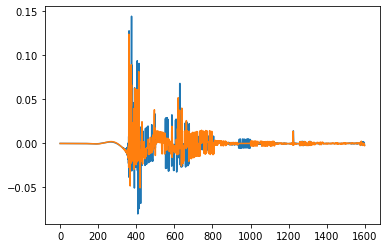

In [34]:
rir = [[s[:rir_len] for s in r] for r in room.rir] # first index is mic, second is source
plt.plot(rir[0][0])
plt.plot(rir[0][1])

In [35]:
sound_paths = glob("../data/reference_data/reference_sounds/*.wav")
sound_path = sound_paths[0]
fs,signal = wavfile.read(sound_path)
sound_path

'../data/reference_data/reference_sounds/Goldberg Variations, BWV. 988 - Variation 14.wav'

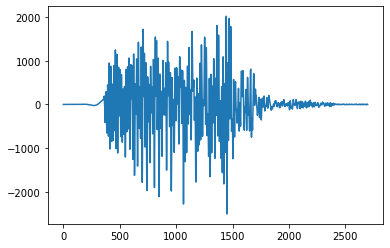

In [70]:
start_idx_signal = len(signal) // 2
end_idx_signal = sample_length + extra_bit + start_idx_signal


s = signal[start_idx_signal:end_idx_signal]

s = s.reshape(simmulated_sender_locations,-1)

#s = np.concatenate([s, np.zeros((simmulated_sender_locations, rir_len))], axis = 1)

i = 0

plt.plot(np.convolve(s[i], rir[0][i]))


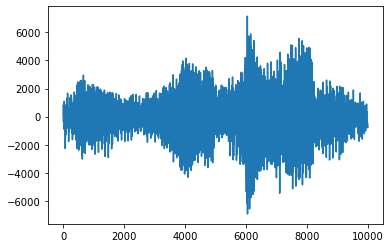

In [106]:
#plt.plot(rir[0][i])
fin_sound = np.zeros(sample_length + extra_bit + rir_len - 1)
for i in range(simmulated_sender_locations):
    played_sound_length = s[i].shape[0]
    sound_and_reverb_length = rir[0][i].shape[0] + s[i].shape[0] - 1
    fin_sound[played_sound_length*i:played_sound_length*i + sound_and_reverb_length] += np.convolve(s[i], rir[0][i])

fin_sound = fin_sound[extra_bit:-rir_len+1]

plt.plot(fin_sound)

#IPython.display.Audio(fin_sound, rate=16000)

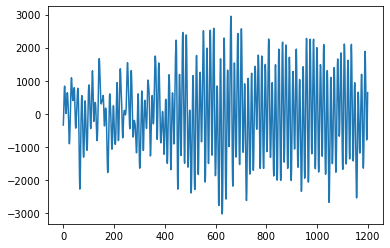

In [93]:
#plt.plot(fin_sound[1000:2200])